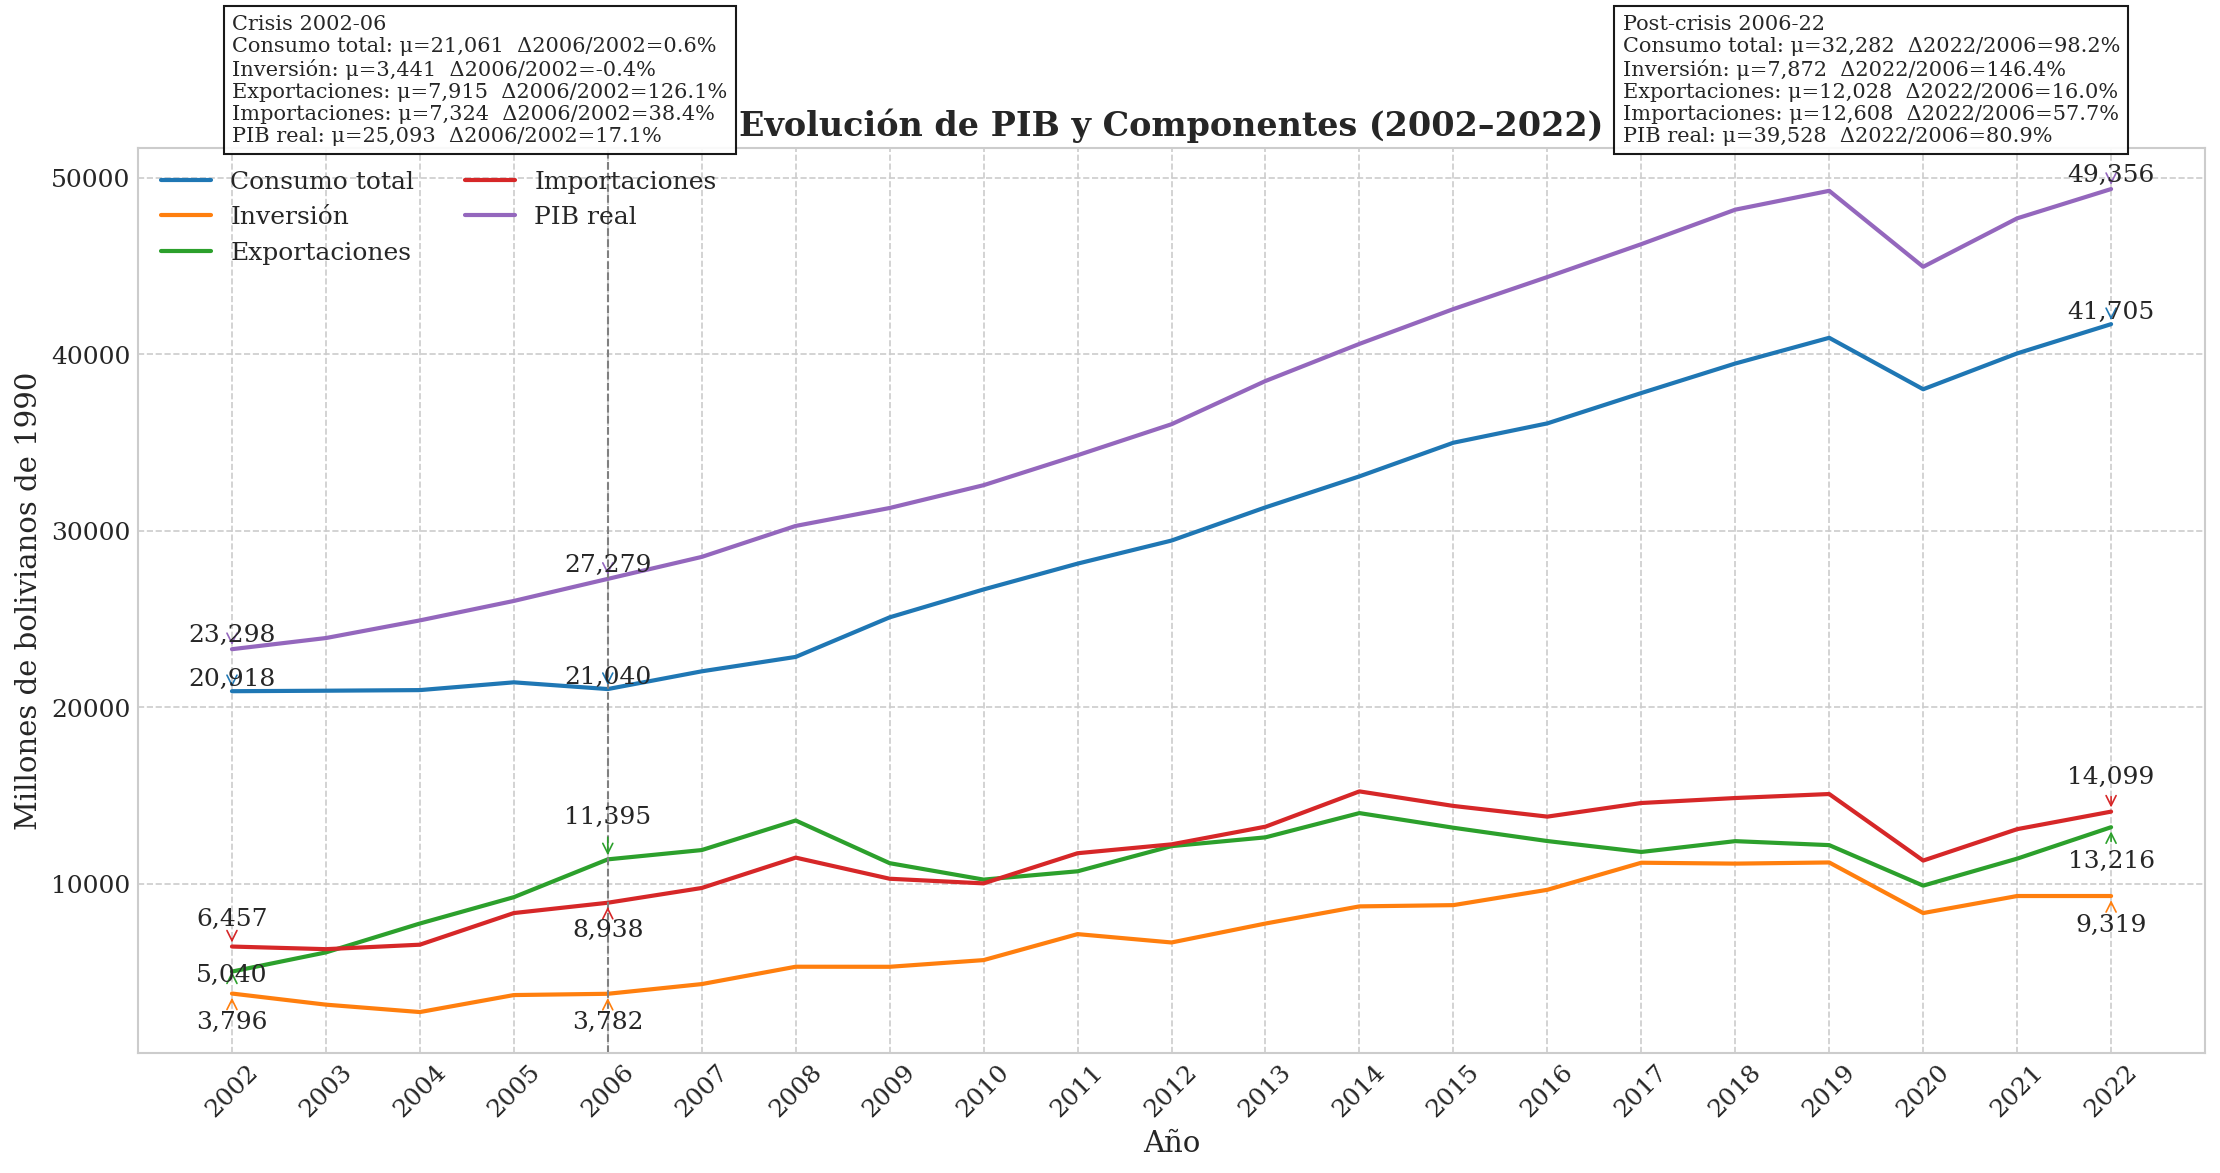

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os

# ── 1. Configuración general y salida ────────────────────────────────
output_dir = "../../../assets/tesis/neoliberalismo/serie_completa"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family'    : 'serif',
    'font.size'      : 12,
    'axes.titlesize' : 16,
    'axes.labelsize' : 14,
    'grid.linestyle' : '--',
    'lines.linewidth': 2,
    'figure.dpi'     : 150,
    'savefig.bbox'   : 'tight'
})

# ── 2. Carga y filtro 2002–2022 ───────────────────────────────────────
with sqlite3.connect('../../../db/proyectomacro.db') as conn:
    df = pd.read_sql_query("SELECT * FROM pib_real_gasto", conn, index_col="año") / 1000

df_full = df = df.loc[2002:2022].copy()
crisis   = df.loc[2002:2006]
post     = df.loc[2006:2022]

# ── 3. Componentes y estadísticas ────────────────────────────────────
componentes = [
    ("gastos_consumo",               "Consumo total"),
    ("formacion_capital",            "Inversión"),
    ("exportacion_bienes_servicios", "Exportaciones"),
    ("importacion_bienes",           "Importaciones"),
    ("pib_real_base_1990",           "PIB real")
]

def cuadro_stats(sub, a, b):
    lines = []
    for col, label in componentes:
        μ     = sub[col].mean()
        Δpct  = (df.loc[b, col] - df.loc[a, col]) / df.loc[a, col] * 100
        lines.append(f"{label}: μ={μ:,.0f}  Δ{b}/{a}={Δpct:.1f}%")
    return "\n".join(lines)

txt_cr = f"Crisis 2002-06\n{cuadro_stats(crisis, 2002, 2006)}"
txt_po = f"Post-crisis 2006-22\n{cuadro_stats(post, 2006, 2022)}"

# ── 4. Offsets para anotaciones ──────────────────────────────────────
annotation_offsets = {
    'gastos_consumo': {
        2002: (0, 300), 2006: (0, 300), 2022: (0, 300),
    },
    'formacion_capital': {
        2002: (0, -2000), 2006: (0, -2000), 2022: (0, -2000),
    },
    'exportacion_bienes_servicios': {
        2002: (0, -600), 2006: (0, 2000), 2022: (0, -2300),
    },
    'importacion_bienes': {
        2002: (0, 1200), 2006: (0, -1900), 2022: (0, 1600),
    },
    'pib_real_base_1990': {
        2002: (0, 400), 2006: (0, 400), 2022: (0, 400),
    }
}

# ── 5. Crear gráfico y anotar ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 8))
cmap = plt.get_cmap('tab10')

for i, (col, label) in enumerate(componentes):
    ax.plot(df.index, df[col], label=label, color=cmap(i))

# Línea divisoria en 2006
ax.axvline(2006, color='gray', linestyle='--', linewidth=1)

# Anotaciones en 2002, 2006, 2022 (excluye consumo privado/público)
for col, _ in componentes:
    for yr in (2002, 2006, 2022):
        y = df.loc[yr, col]
        dx, dy = annotation_offsets[col].get(yr, (0, y*0.05))
        ax.annotate(f"{y:,.0f}",
                    xy=(yr, y),
                    xytext=(yr + dx, y + dy),
                    ha='center',
                    fontsize=12,
                    arrowprops=dict(arrowstyle='->', color=cmap([c[0] for c in componentes].index(col)), linewidth=0.8))

# Texto de estadísticas
ybox = df_full.values.max() * 1.2
ax.text(2002, ybox, txt_cr,
        fontsize=10, va='top',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))

ax.text(2016.8, ybox, txt_po,
        fontsize=10, va='top',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))

# Etiquetas y formato final
ax.set_title("Evolución de PIB y Componentes (2002–2022)", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos de 1990")
ax.set_xticks(range(2002, 2023))
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_componentes_2002_22.png"))
plt.show()